# 不可压库埃特流（couette flow）的数值解

库埃特流（couette flow）指的是粘性流体在相对运动着的两平行平板之间的层流流动。

假设有两个距离$D$的平板，上平板以速度$u_e$运动，下平板静止，考虑俩平板之间的粘性流动，如图所示。
![couette_flow](couette_flow.png)
假设流体是不可压缩，且恒温的，其N-S方程可以简化为$$\frac{\partial^2 u}{\partial y^2}=0$$

上式有解析解，为$$u=u_e\frac{y}{D}$$

下面用数值方法求解，假设速度剖面为
$$u=\begin{cases}0 \qquad 0\leq y<D\\u_e \qquad y=D \end{cases}$$
将其作为计算的初始速度，从初始条件出发，建立流场的时间推进解法。

非定常流动控制方程为$$ \rho \frac{\partial u}{\partial t}=\mu \frac{\partial^2 u}{\partial y^2}$$

为计算方便，首先定义无量纲变量$$u'=\frac{u}{u_e} \quad y'=\frac{y}{D} \quad t'=\frac{t}{D/u_e}$$

将控制方程无量纲化，化简得$$\frac{\partial u'}{\partial t'}=\frac{\mu}{\rho u_e D} \frac{\partial^2 u'}{\partial y'^2}$$

可以发现 $$\frac{\mu}{\rho u_e D}\equiv \frac{1}{Re_D}$$

其中$Re_D$是按照两平板之间距离计算的雷诺数，于是控制方程变为（省略变量上的`’`符号）$$\frac{\partial u}{\partial t}=\frac{1}{Re_D} \frac{\partial^2 u}{\partial y^2}$$

利用[克兰克-尼科尔森](https://zh.wikipedia.org/wiki/%E5%85%8B%E5%85%B0%E5%85%8B%EF%BC%8D%E5%B0%BC%E7%A7%91%E5%B0%94%E6%A3%AE%E6%96%B9%E6%B3%95)差分格式，上式化为 $$u_j^{n+1}=u_j^n+\frac{\Delta t}{2(\Delta y)^2 Re_D}(u_{j+1}^{n+1}+u_{j+1}^n-2u_j^{n+1}-2u_j^n+u_{j-1}^{n+1}+u_{j-1}^n)$$
移项并整理表示成下式：
$$\boxed{Au_{j-1}^{n+1}+Bu_j^{n+1}+A_{j+1}^{n+1}=K_j}$$
其中$$A=-\frac{\Delta t}{2(\Delta y)^2 Re_D} \\ B=1+\frac{\Delta t}{(\Delta y)^2 Re_D} \\ K_j=[1-\frac{\Delta t}{(\Delta y)^2 Re_D}]u_j^n+\frac{\Delta t}{2(\Delta y) Re_D}(u_{j+1}^n+u_{j-1}^n)$$

将方块内式子表示成矩阵形式
$$
\begin{pmatrix} B & A & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ A & B & A & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & A & B & A & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & A & B & A & 0 & 0 & 0 & 0 \\ & & & \cdots \\ & & & & \cdots \\ & & & & & \cdots \\ \\ 0 & 0 & 0 & 0 & 0 & 0 & A & B & A\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & A & B \end{pmatrix}\begin{pmatrix} u_2^{n+1} \\ u_3^{n+1} \\ u_4^{n+1} \\ u_5^{n+1} \\ \vdots \\ u_{N-1}^{n+1} \\ u_N^{n+1} \end{pmatrix}=\begin{pmatrix} K_2 \\ K_3 \\ K_4 \\ K_5 \\ \vdots \\ K_{N-1} \\ K_N-A  \end{pmatrix}
$$

使用追赶法（托马斯算法）求解上式。

In [1]:
%pylab

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


算法：（参考《现代数值计算》P45的matlab算法）

In [2]:
def tridiagsolver(A,b):
    n,n = A.shape
    l=zeros(n)
    u=zeros(n-1)
    y=zeros(n)
    x=zeros(n)
    for i in range(n):
        if i==0:
            l[i] = A[i,i]
            y[i]=b[i]/l[i]
        else:
            l[i]=A[i,i]-A[i,i-1]*u[i-1]
            y[i]=(b[i]-y[i-1]*A[i,i-1])/l[i]
        if i<n-1:
            u[i]=A[i,i+1]/l[i]
    x[n-1]=y[n-1]
    for j in range(n-2,-1,-1):
        x[j]=y[j]-u[j]*x[j+1]
    return x

举例：

In [3]:
A=array([[2,-1,0,0],[-1,3,-2,0],[0,-2,4,-3],[0,0,-3,5]])
b=array([[6],[1],[-2],[1]])
x=tridiagsolver(A,b)
print(x)

[ 5.  4.  3.  2.]


选取21个网格点进行计算，本例采用的差分格式是无条件稳定的，参考显性格式的稳定性条件：$$\frac{\alpha \Delta t}{(\Delta x)^2}\leq \frac{1}{2}$$

进行无量纲化，得$$\Delta t \leq  \frac{1}{2}Re_D(\Delta y)^2$$

受此启发，我们取$$\Delta t = E Re_D(\Delta y)^2$$

由于无条件稳定，E可以取任何值。

从而简化$A \quad B \quad K_j$
即$$A = -\frac{E}{2}\\ B=1+E \\K_j=(1-E)u_j^n+\frac{E}{2}(u_{j-1}^n)$$

下面取$E=1\quad Re_D=5000$进行计算

In [4]:
%matplotlib inline

In [5]:
def interation(E,N):
    A=-E/2
    B=1+E
    T=diag([B,B,B,B,B,B,B,B,B,B,B,B,B,B,B,B,B,B,B])+\
        diag([A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A],-1)+\
        diag([A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A],1)
    K=array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]) #初始条件计算出的K
    u=tridiagsolver(T,K) 
    u0=0.0
    u20=1.0
    j=0
    while j<N:
        K=ones(19)
        for i in range(19):
            if i==0:
                K[i]=(1-E)*u[i]+E/2*(u[i+1]+u0)
            elif i==18:
                K[i]=(1-E)*u[i]+E/2*(u20+u[i-1])-A
            elif  i>0 and i<18:
                K[i]=(1-E)*u[i]+E/2*(u[i+1]+u[i-1])
        u=tridiagsolver(T,K) 
        j=j+1
    u = insert(u,(0,19),[0.0,1.0])
    print(u)
    plot(u,linspace(0,1,21))

观察多次迭代后结果

[  0.00000000e+00   5.48708995e-10   2.09397349e-09   7.42373505e-09
   2.60880294e-08   9.12800836e-08   3.17952046e-07   1.10185536e-06
   3.79585871e-06   1.29858095e-05   4.40579097e-05   1.47983722e-04
   4.90918016e-04   1.60311461e-03   5.12820443e-03   1.59489329e-02
   4.76177823e-02   1.33283987e-01   3.31615075e-01   6.18802154e-01
   1.00000000e+00]
[  0.00000000e+00   6.99964926e-05   1.82270795e-04   3.99300235e-04
   8.30225200e-04   1.67007156e-03   3.25803404e-03   6.15923686e-03
   1.12691737e-02   1.99301613e-02   3.40347728e-02   5.60752987e-02
   8.90872686e-02   1.36437615e-01   2.01431498e-01   2.86759285e-01
   3.93862672e-01   5.22359476e-01   6.69682022e-01   8.31074200e-01
   1.00000000e+00]
[ 0.          0.04174087  0.08368476  0.12602969  0.1689639   0.21266122
  0.25727677  0.30294321  0.34976739  0.39782778  0.44717246  0.49781794
  0.54974867  0.60291744  0.65724648  0.71262936  0.76893361  0.82600392
  0.88366603  0.94173103  1.        ]
[ 0.    0.05  0

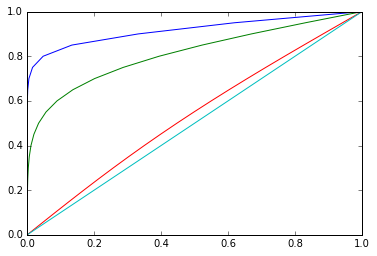

In [6]:
interation(1,1)
interation(1,10)
interation(1,100)
interation(1,1000)

可见当迭代次数足够多时，流动趋于稳定，逼近数值解。

补充：尝试取不同的$E$，即不同的$\Delta t$进行计算，观察结果。

[ 0.          0.05000133  0.10000411  0.15000854  0.20001237  0.25001018
  0.2999947   0.34996237  0.39992443  0.44991985  0.50001476  0.5502561
  0.600544    0.65045016  0.69923788  0.74679282  0.79639222  0.8574941
  0.93058654  0.8933234   1.        ]
[ 0.          0.05        0.1         0.15        0.2         0.25
  0.29999999  0.35000001  0.40000005  0.45000001  0.49999976  0.54999976
  0.60000121  0.65000165  0.69999171  0.74999507  0.800077    0.84979759
  0.90028724  0.94978175  1.        ]


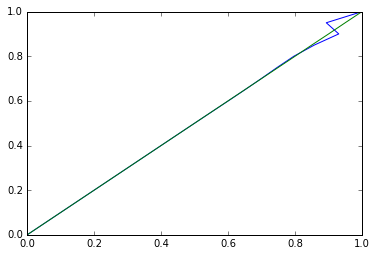

In [7]:
interation(1000,1000)
interation(1000,5000)

可见当E过大时，效果反而不好，需要迭代更多次。所以**大时间步长的隐式格式不适合计算关心瞬时结果的问题**。

参考：《计算流体力学基础及应用》 John D. Anderson

        《现代数值计算》 同济大学